# Exact QEP Regression on Classification Labels

In this notebok, we demonstrate how one can convert classification problems into regression problems by performing fixed noise regression on the classification labels. 

We follow the method of [Dirichlet-based Gaussian Processes for Large-Scale Calibrated Classification](https://papers.nips.cc/paper/2018/file/b6617980ce90f637e68c3ebe8b9be745-Paper.pdf) who transform classification targets into regression ones by using an approximate likelihood.

In [1]:
import math
import torch
import numpy as np
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library 'libomp' not found.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Generate Data

Firs, we will generate 500 data points from a smooth underlying latent function and have the inputs be iid Gaussian.
The decision boundaries are given by rounding a latent function:

$f(x,y) = \sin(0.15 \pi u + (x + y)) + 1,$ where $u \sim \text{Unif}(0,1).$
Then, $y = \text{round}(f(x,y)).$

In [2]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)
    
    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)
    
    u = torch.rand(1)
    data_fn = lambda x, y: 1 * torch.sin(0.15 * u * 3.1415 * (x + y)) + 1
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn

In [3]:
train_x, train_y, genfn = gen_data(500)

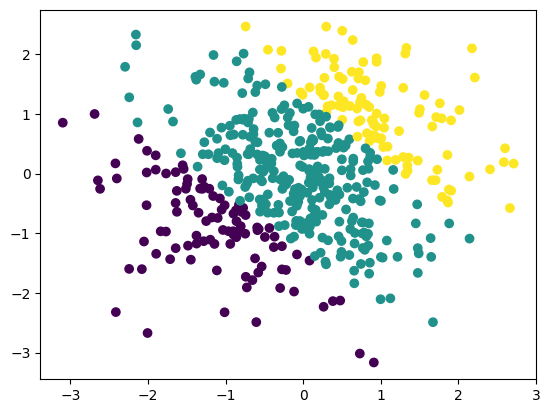

In [4]:
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

The below plots illustrate the decision boundary. We will predict the class logits and ultimately the predictions across $[-3, 3]^2$ for illustration; this region contains both interpolation and extrapolation.

In [5]:
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

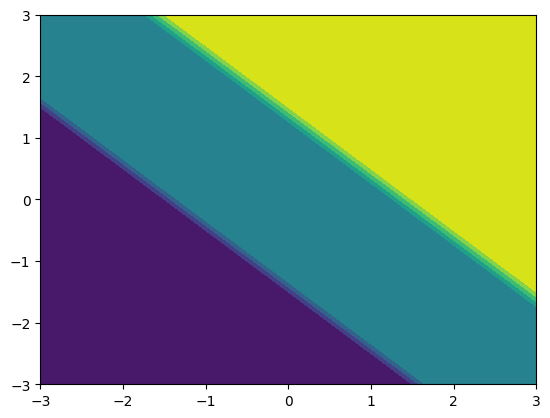

In [6]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

## Setting Up the Model

The Dirichlet QEP model is an exact QEP model with a couple of caveats. First, it uses a special likelihood: a DirichletClassificationLikelihood, and second, it is natively a multi-output model (for each data point, we need to predict `num_classes`, $C$, outputs) so we need to specify the batch shape for our mean and covariance functions.

The DirichletClassificationLikelhood is just a special type of `FixedQExponentialNoiseLikelihood` that does the required data transformations into a regression problem for us. Succinctly, we soft one hot encode the labels into $C$ outputs so that $\alpha_i = \alpha_\epsilon$ if $y_c=0$ and $\alpha_i = 1 + \alpha_\epsilon$ if $y_c=1.$
Then, our variances are $\sigma^2 = \log(1./\alpha + 1.)$ and our targets are $\log(\alpha) - 0.5 \sigma^2.$

That is, rather than a classification problem, we have a regression problem with $C$ outputs.
For more details, please see the original paper.

In [7]:
from qpytorch.models import ExactQEP
from qpytorch.likelihoods import QExponentialDirichletClassificationLikelihood
from qpytorch.means import ConstantMean
from qpytorch.kernels import ScaleKernel, RBFKernel

In [10]:
# We will use the simplest form of QEP model, exact inference
POWER = 1.0
class DirichletQEPModel(ExactQEP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletQEPModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

# initialize likelihood and model
# we let the QExponentialDirichletClassificationLikelihood compute the targets for us
likelihood = QExponentialDirichletClassificationLikelihood(train_y, learn_additional_noise=True, power=torch.tensor(POWER))
model = DirichletQEPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

Now we train and fit the model as we would any other GPyTorch model.

In [11]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 9.540   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 9.207   lengthscale: 0.958   noise: 0.475
Iter 11/50 - Loss: 9.062   lengthscale: 1.171   noise: 0.321
Iter 16/50 - Loss: 8.977   lengthscale: 1.239   noise: 0.219
Iter 21/50 - Loss: 8.901   lengthscale: 1.172   noise: 0.153
Iter 26/50 - Loss: 8.831   lengthscale: 1.036   noise: 0.111
Iter 31/50 - Loss: 8.779   lengthscale: 0.887   noise: 0.084
Iter 36/50 - Loss: 8.734   lengthscale: 0.737   noise: 0.066
Iter 41/50 - Loss: 8.668   lengthscale: 0.609   noise: 0.053
Iter 46/50 - Loss: 8.654   lengthscale: 0.570   noise: 0.044


## Model Predictions

In [13]:
model.eval()
likelihood.eval()

with qpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    
    pred_means = test_dist.loc

We've predicted the logits for each class in the classification problem, and can clearly see that the logits for class 0 are highest in the bottom left, the logits for class 2 are highest in the top right, and the logits for class 1 are highest in the middle.

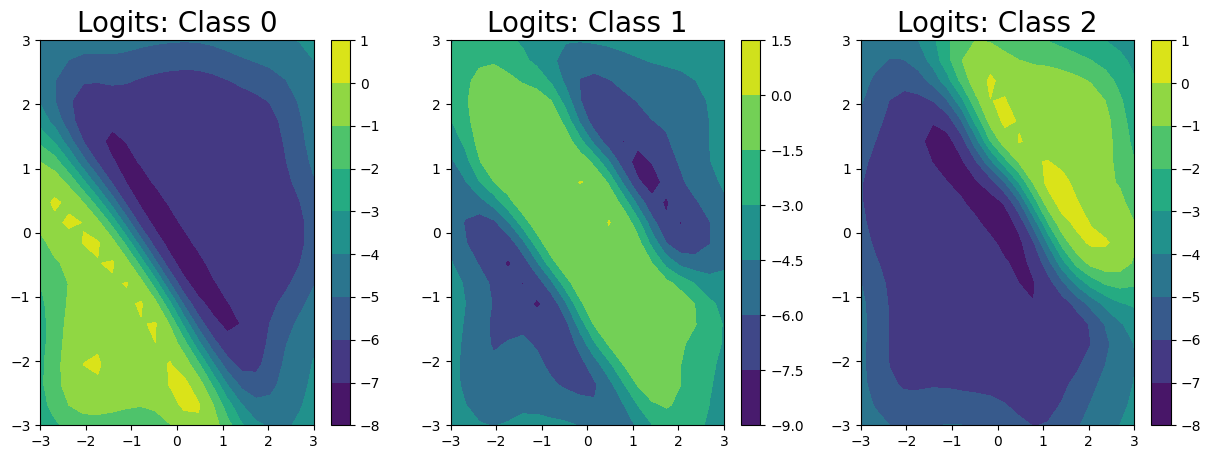

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)


Unfortunately, we can't get closed form estimates of the probabilities; however, we can approximate them with a lightweight sampling step using $J$ samples from the posterior as:
$$\mathbb{E}(p(y_i = j)) = \int \frac{\exp\{f_i^*\}}{\sum_k^C \exp\{f_i^*\}} p(f^* | y) df^* \approx \frac{1}{J} \sum_j^J \frac{\exp\{f_{i,j}^*\}}{\sum_k^C \exp\{f_{i,j}^*\}}$$

Here, we draw $256$ samples from the posterior.

In [15]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

/Users/shiweilan/miniconda/envs/qpytorch/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/shiweilan/miniconda/envs/qpytorch/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/shiweilan/miniconda/envs/qpytorch/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


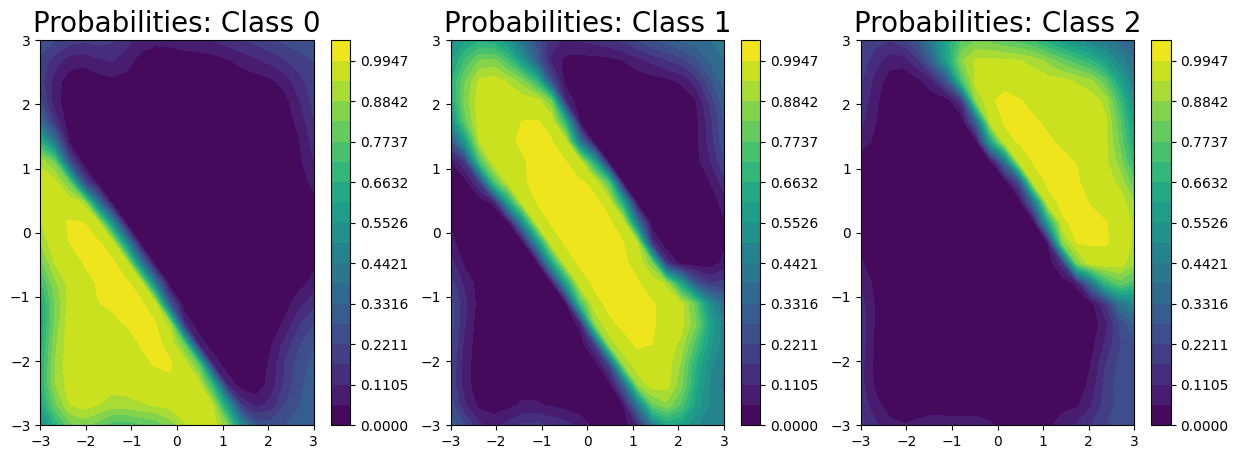

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Finally, we plot the decision boundary (on the right) and the true decision boundary on the left. They align pretty closely.

To get the decision boundary from our model, all we need to do is to compute the elementwise maximium at each test point.

Text(0.5, 1.0, 'Estimated Response')

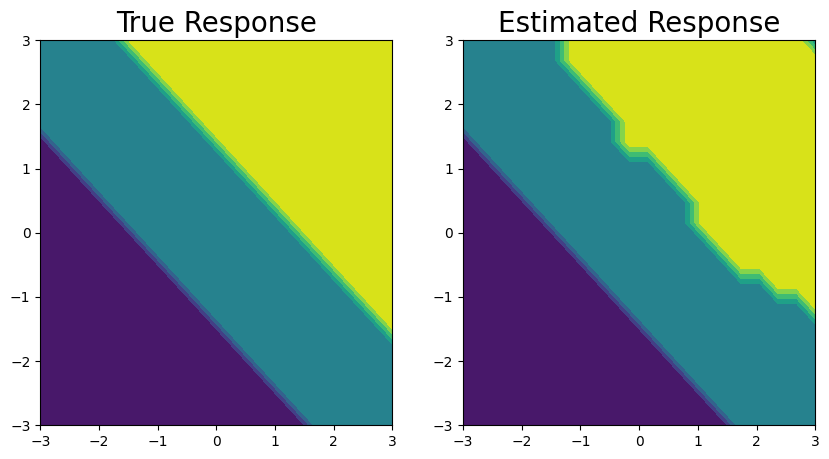

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)